In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import trapz
from sklearn.decomposition import PCA

In [78]:
# Data loading

dataset = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
dataset = dataset.drop([0, 1, 2, 3, 504], axis=1)
dataset.columns = list(range(500))
dataset.head()
dataset.shape


(23479, 500)

In [79]:
dataset.shape

(23479, 500)

Text(0, 0.5, 'bit ADC')

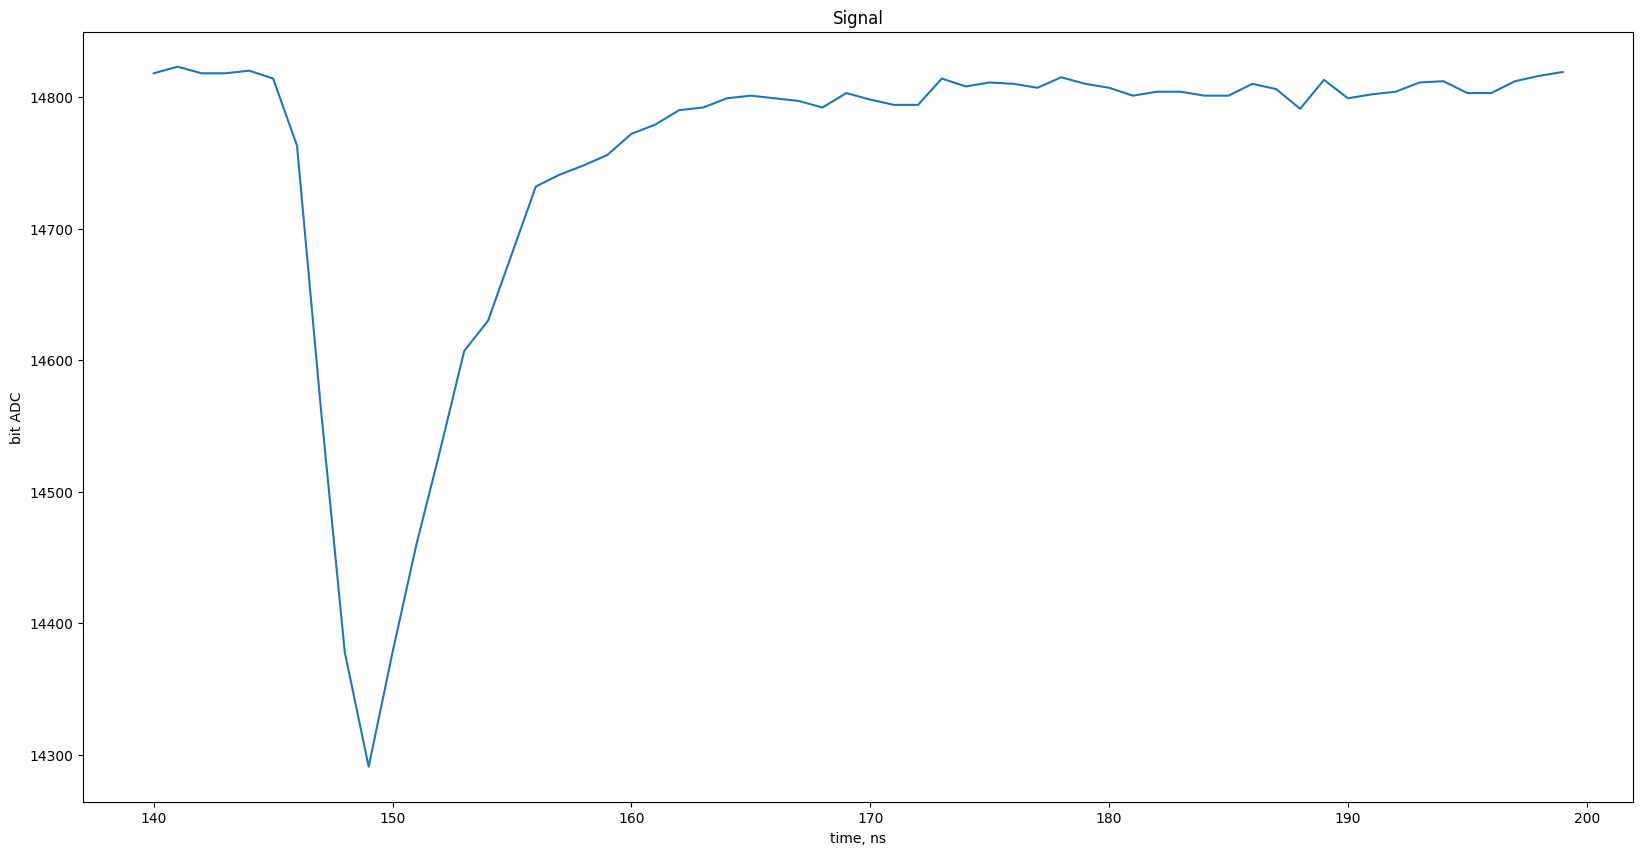

In [80]:
N=range(0,1)
ax = dataset.T[N][140:200].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

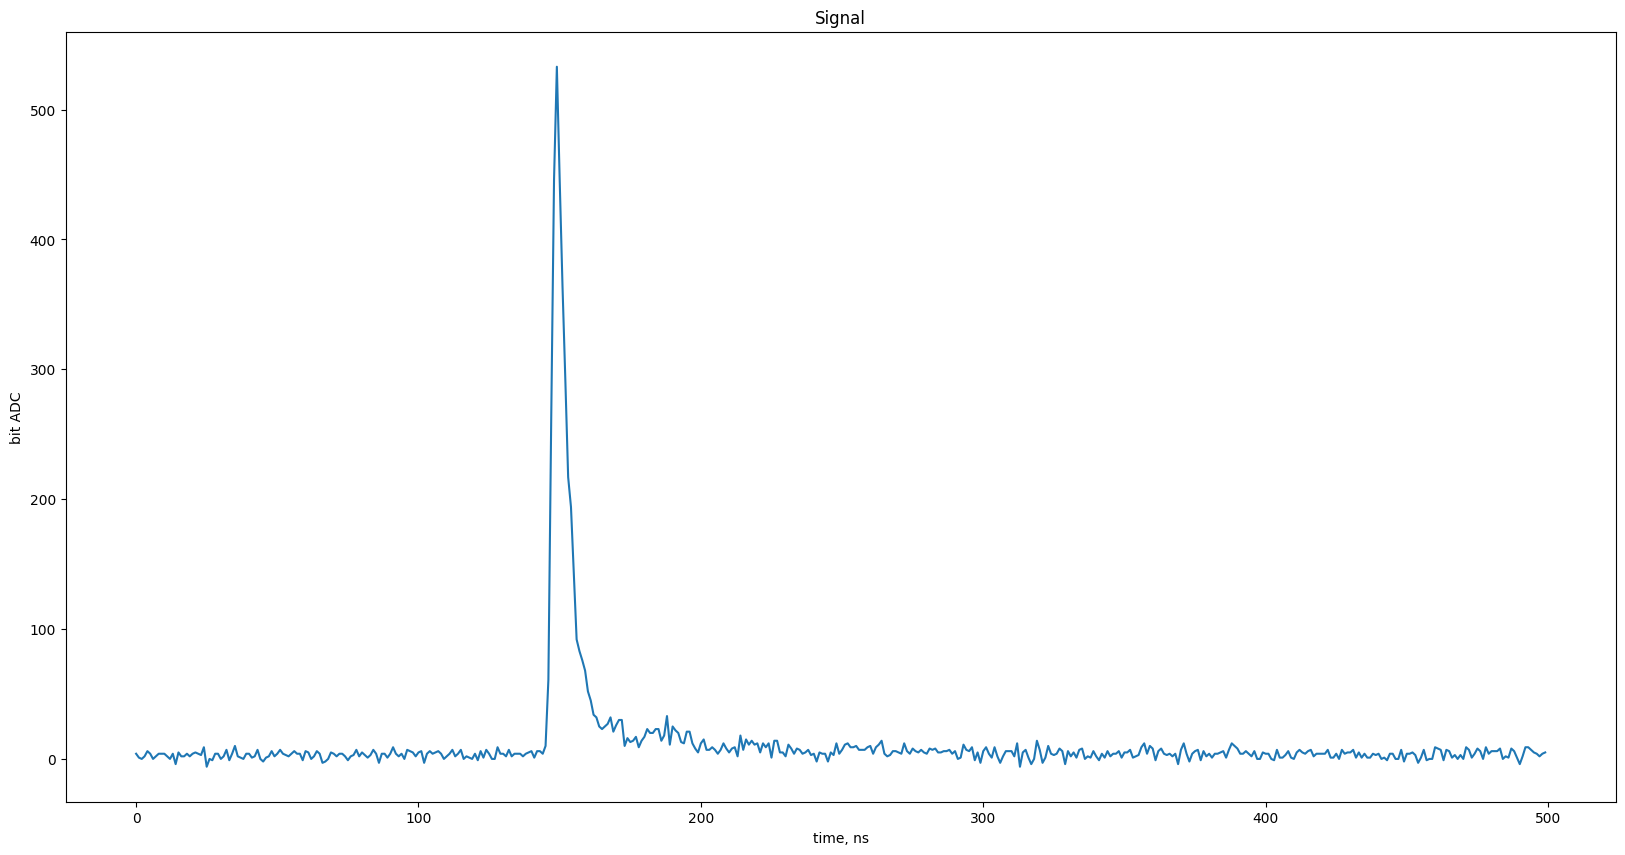

In [81]:
N=range(0,1)
ax = (2**14-dataset.T[N]-1560)[0:500].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

Text(0, 0.5, 'bit ADC')

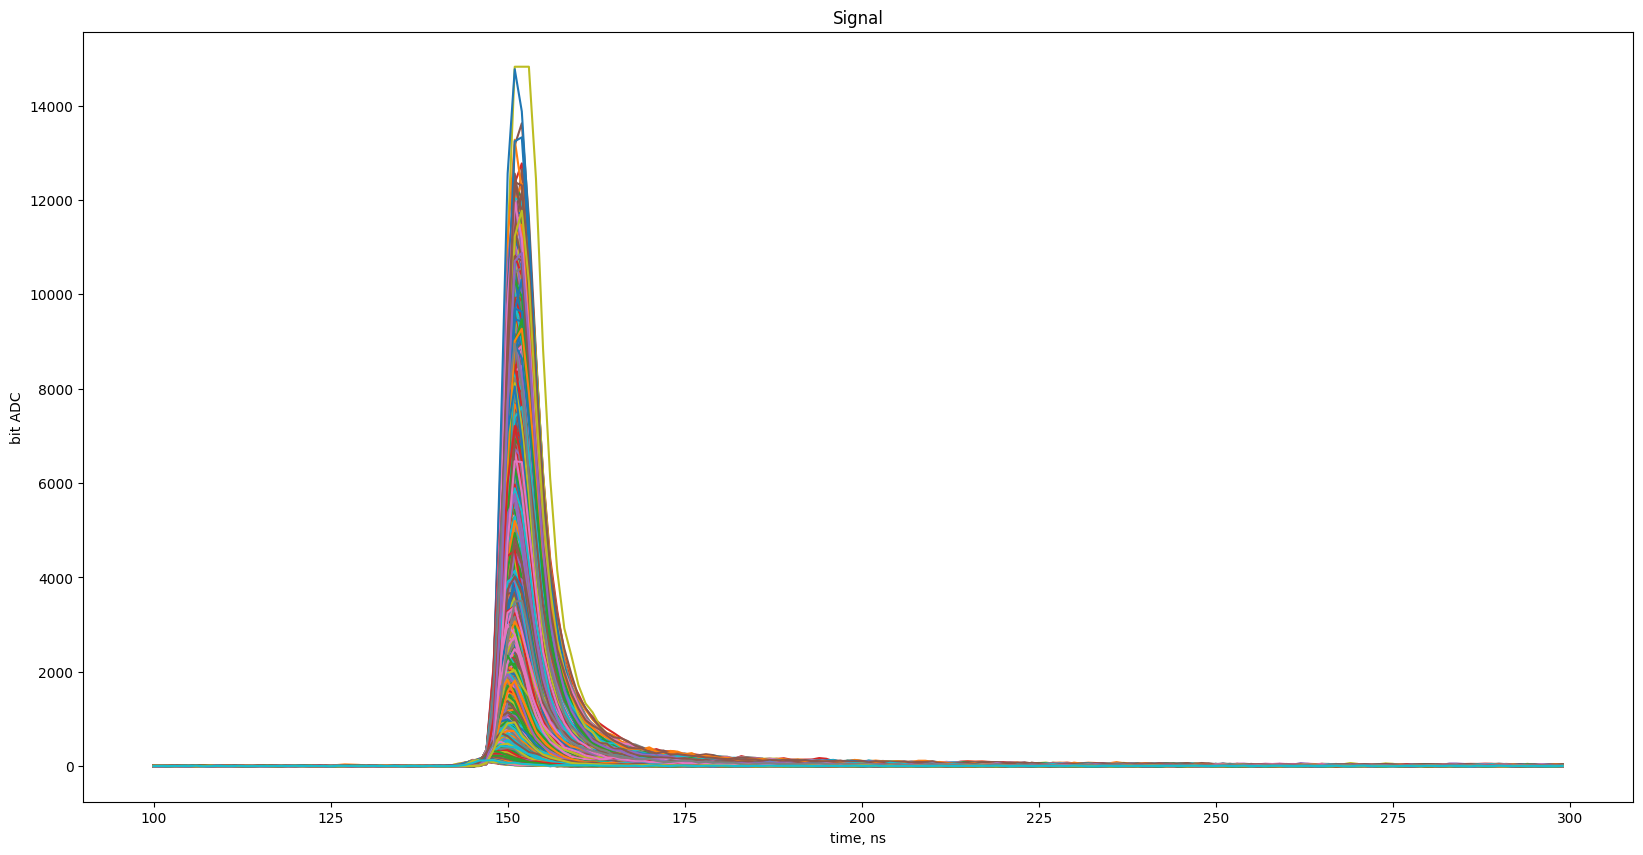

In [82]:
N=range(0,4000)
ax = (2**14-dataset.T[N]-1560)[100:300].plot(title='Signal' ,legend=None,figsize=(20,10))
ax.set_xlabel("time, ns")
ax.set_ylabel("bit ADC")

#### Выделяем "сигнал"

In [83]:
data = (2**14-dataset.T-1560)[140:200]
data.shape

(60, 23479)

#### Находим "Сигнал"

In [84]:
# import numpy as np
# import pandas as pd

# def mask_non_signal_values(data, n_baseline=50, n_sigma=3):
#     data_masked = data.copy()
#     n_signals, n_points = data.shape
#     for i in range(n_signals):
#         # Получаем i-й сигнал
#         signal = data.iloc[i].values
#         # 1. Определяем нулевую линию и шум (по первым n_baseline отсчётам)
#         baseline = np.mean(signal[:n_baseline])
#         noise_std = np.std(signal[:n_baseline])
#         # 2. Находим максимум сигнала
#         i_max = np.argmax(signal)
#         amplitude = signal[i_max] - baseline
#         # 3. Определяем порог для конца сигнала
#         threshold_end = baseline + n_sigma * noise_std
#         # 4. Находим начало сигнала (с отступом от максимума)
#         offset = 2
#         signal_start = min(i_max + offset, n_points - 1)
#         # 5. Находим конец сигнала (где значение < порога)
#         signal_end = n_points  # по умолчанию - до конца
#         for j in range(i_max, n_points):
#             if signal[j] < threshold_end:
#                 signal_end = j
#                 break
#         # 6. Создаём маску: True - часть сигнала, False - не сигнал
#         mask = np.zeros(n_points, dtype=bool)
#         mask[signal_start:signal_end] = True
        
#         # 7. Заменяем значения вне сигнала на 0
#         signal_masked = signal.copy()
#         signal_masked[~mask] = 0
        
#         # 8. Обновляем строку в DataFrame
#         data_masked.iloc[i] = signal_masked
    
#     return data_masked

#### Считаем long area

In [85]:
df = pd.DataFrame()
df["volume"] = trapz(data,dx=1, axis=0)

C:\Users\User\AppData\Local\Temp\ipykernel_24732\3948387801.py:2: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  df["volume"] = trapz(data,dx=1, axis=0)


#### Добавляем максимумы амплитуды

In [86]:
df["amplitude"] = data.max(axis=0)
df.shape

(23479, 2)

#### Диаграмма площадь/амплитуда

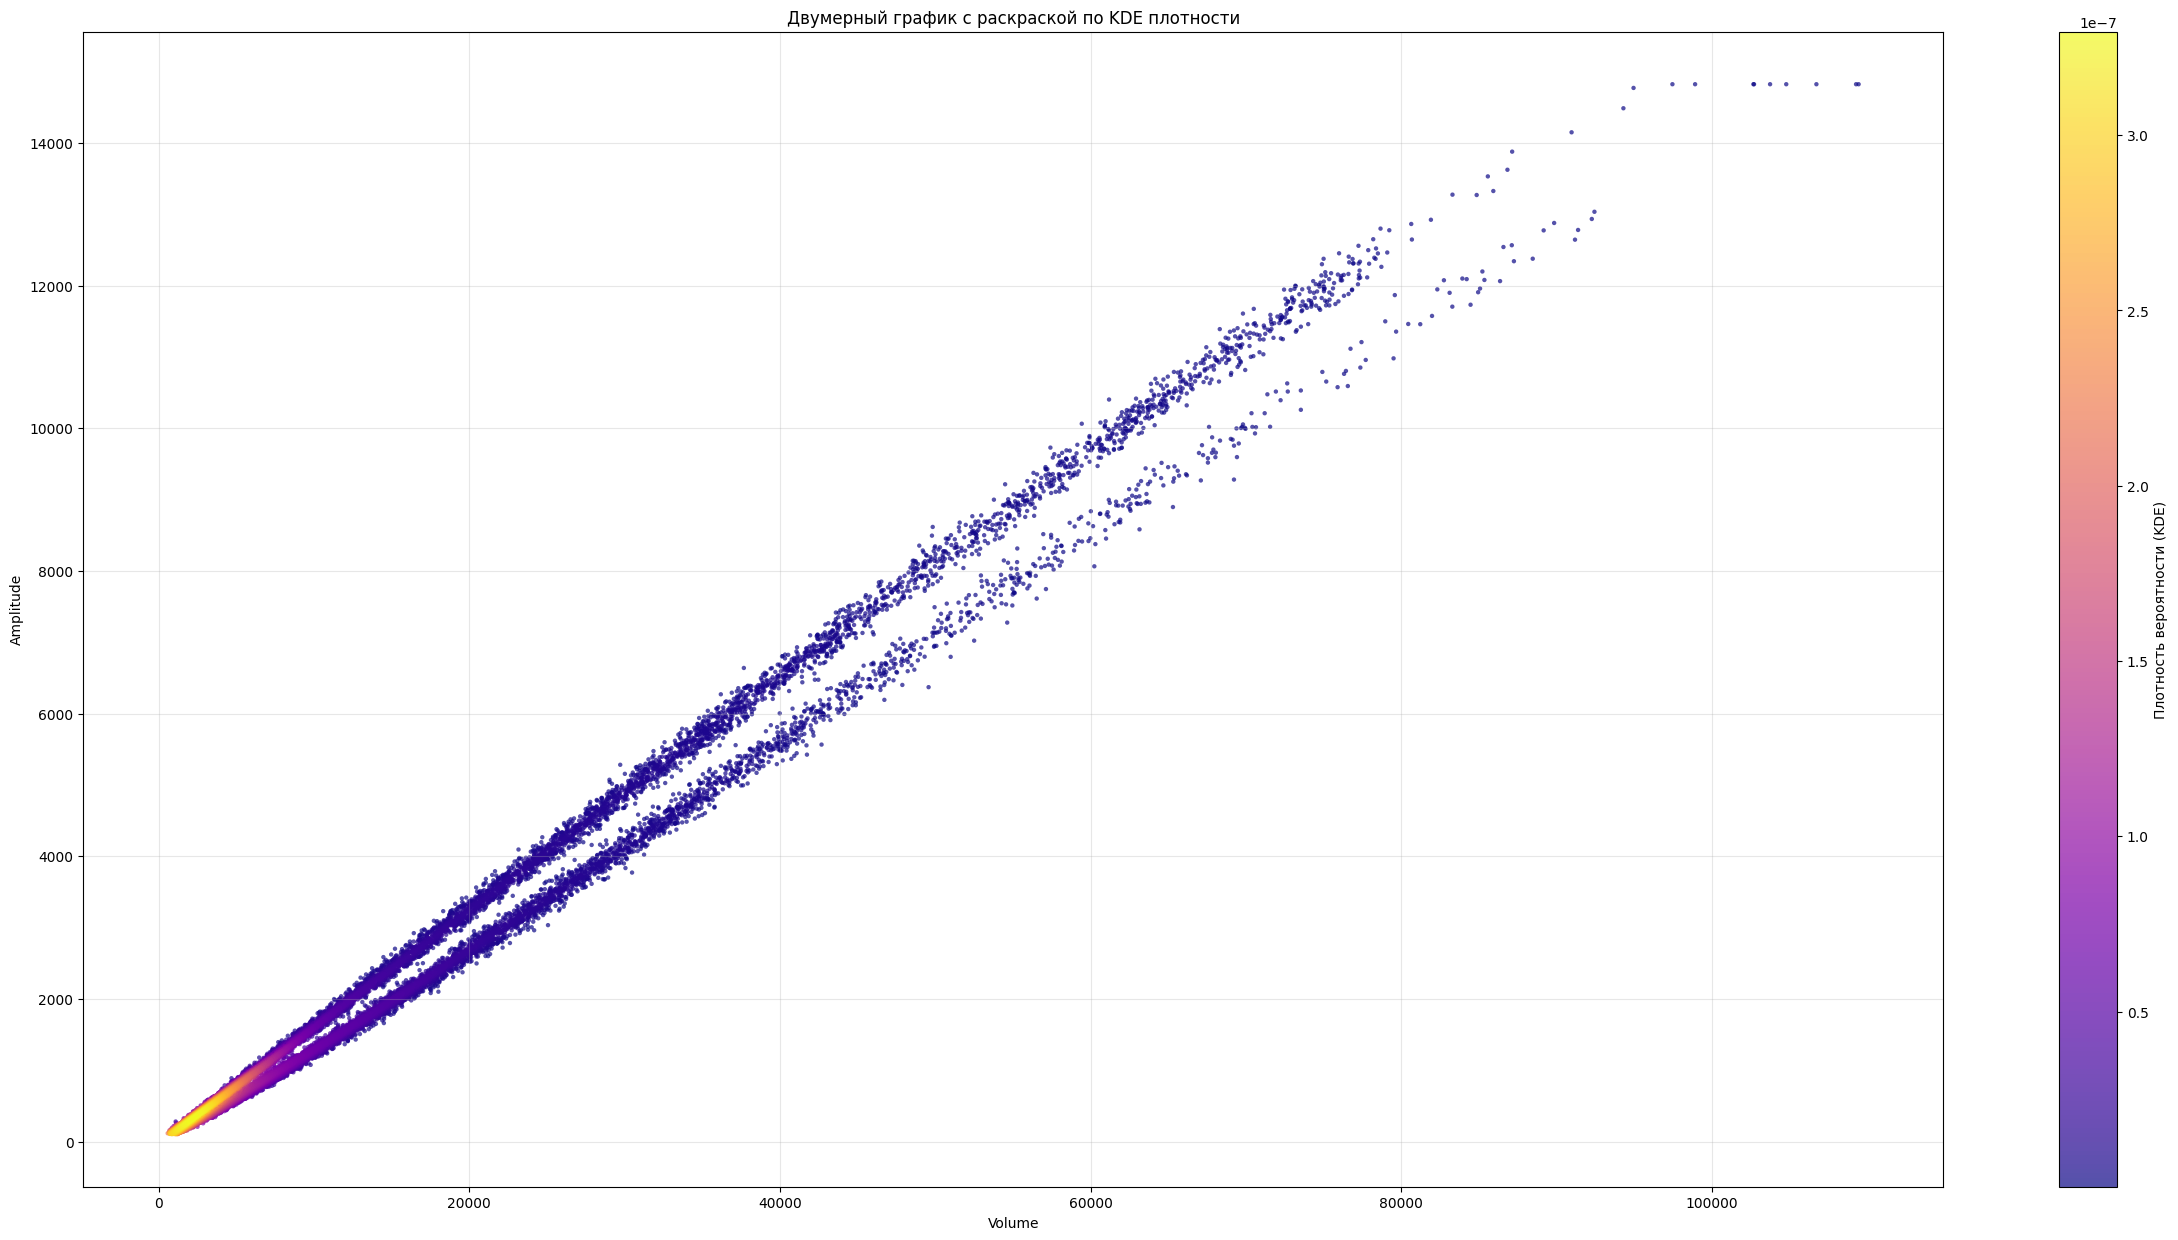

In [87]:
from scipy.stats import gaussian_kde
import numpy as np

plt.figure(figsize=(30, 15))

# Вычисляем ядерную оценку плотности
xy = np.vstack([df['volume'], df['amplitude']])
kde = gaussian_kde(xy)
density = kde(xy)

# Сортируем точки по плотности для правильного отображения
sorted_idx = density.argsort()

plt.scatter(df['volume'].iloc[sorted_idx], 
            df['amplitude'].iloc[sorted_idx], 
            c=density[sorted_idx], 
            cmap='plasma',  # цветовая карта
            s=10,  # размер точек
            alpha=0.7,
            edgecolors='none')

# Добавляем colorbar
plt.colorbar(label='Плотность вероятности (KDE)')

plt.xlabel("Volume")
plt.ylabel("Amplitude")
plt.title("Двумерный график с раскраской по KDE плотности")
plt.grid(True, alpha=0.3)
plt.show()

In [88]:
from sklearn.preprocessing import StandardScaler
X = df[['volume', 'amplitude']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


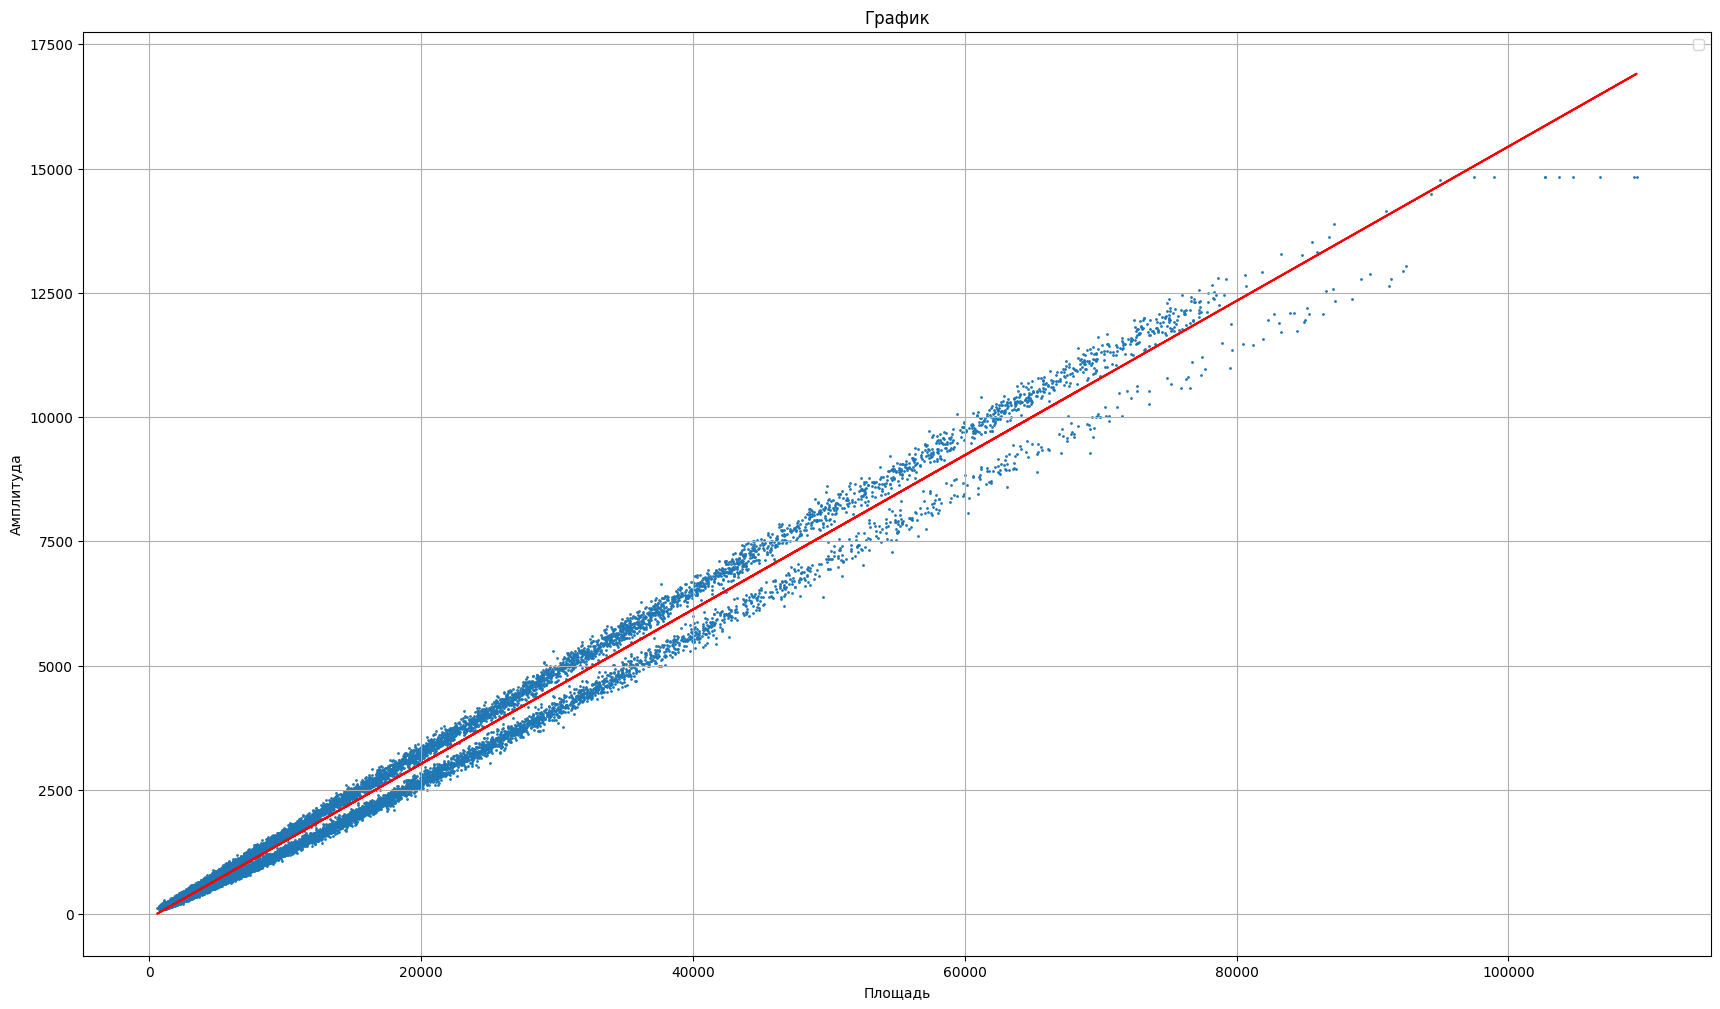

In [89]:
from sklearn.linear_model import LinearRegression
volume = np.array(df['volume']).reshape(-1, 1)
ampl = np.array(df['amplitude']).reshape(-1, 1)
model = LinearRegression()
model.fit(volume, ampl)
line = model.predict(volume)

plt.figure(figsize=(21,12))
plt.scatter(volume, ampl, s=1)
plt.plot(volume, line, color='red')
plt.xlabel('Площадь')
plt.ylabel('Амплитуда')
plt.title('График')
plt.legend()
plt.grid()
plt.show()

In [90]:
x_1 = np.linspace(0, 1, 17)
y_1 = np.array(-dataset.loc[:,140:156] + 2**14 - 1560) # short
a_short = np.trapz(y_1, x_1)
x_2 = np.linspace(0,1,61)
y_2 = np.array(-dataset.loc[:,140:200] + 2**14 - 1560) # long
a_long = np.trapz(y_2, x_2)
psd = (a_long - a_short) / a_long
df['psd'] = psd

Text(0.5, 1.0, 'Гистограмма рассеяния')

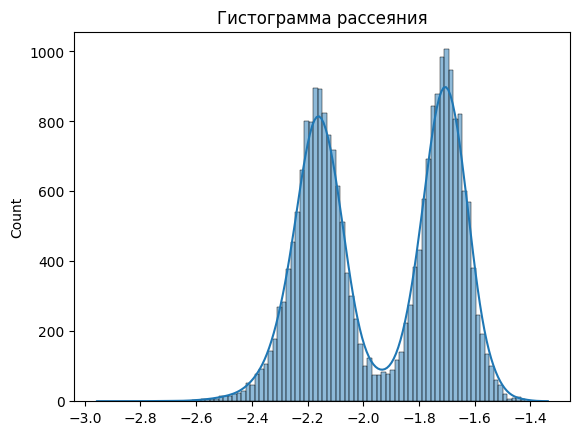

In [91]:
sns.histplot(psd, bins=100, kde=True)
plt.title('Гистограмма рассеяния')

In [92]:
scaler1 = StandardScaler()
X_scaled = scaler1.fit_transform(df[['psd', 'amplitude']])

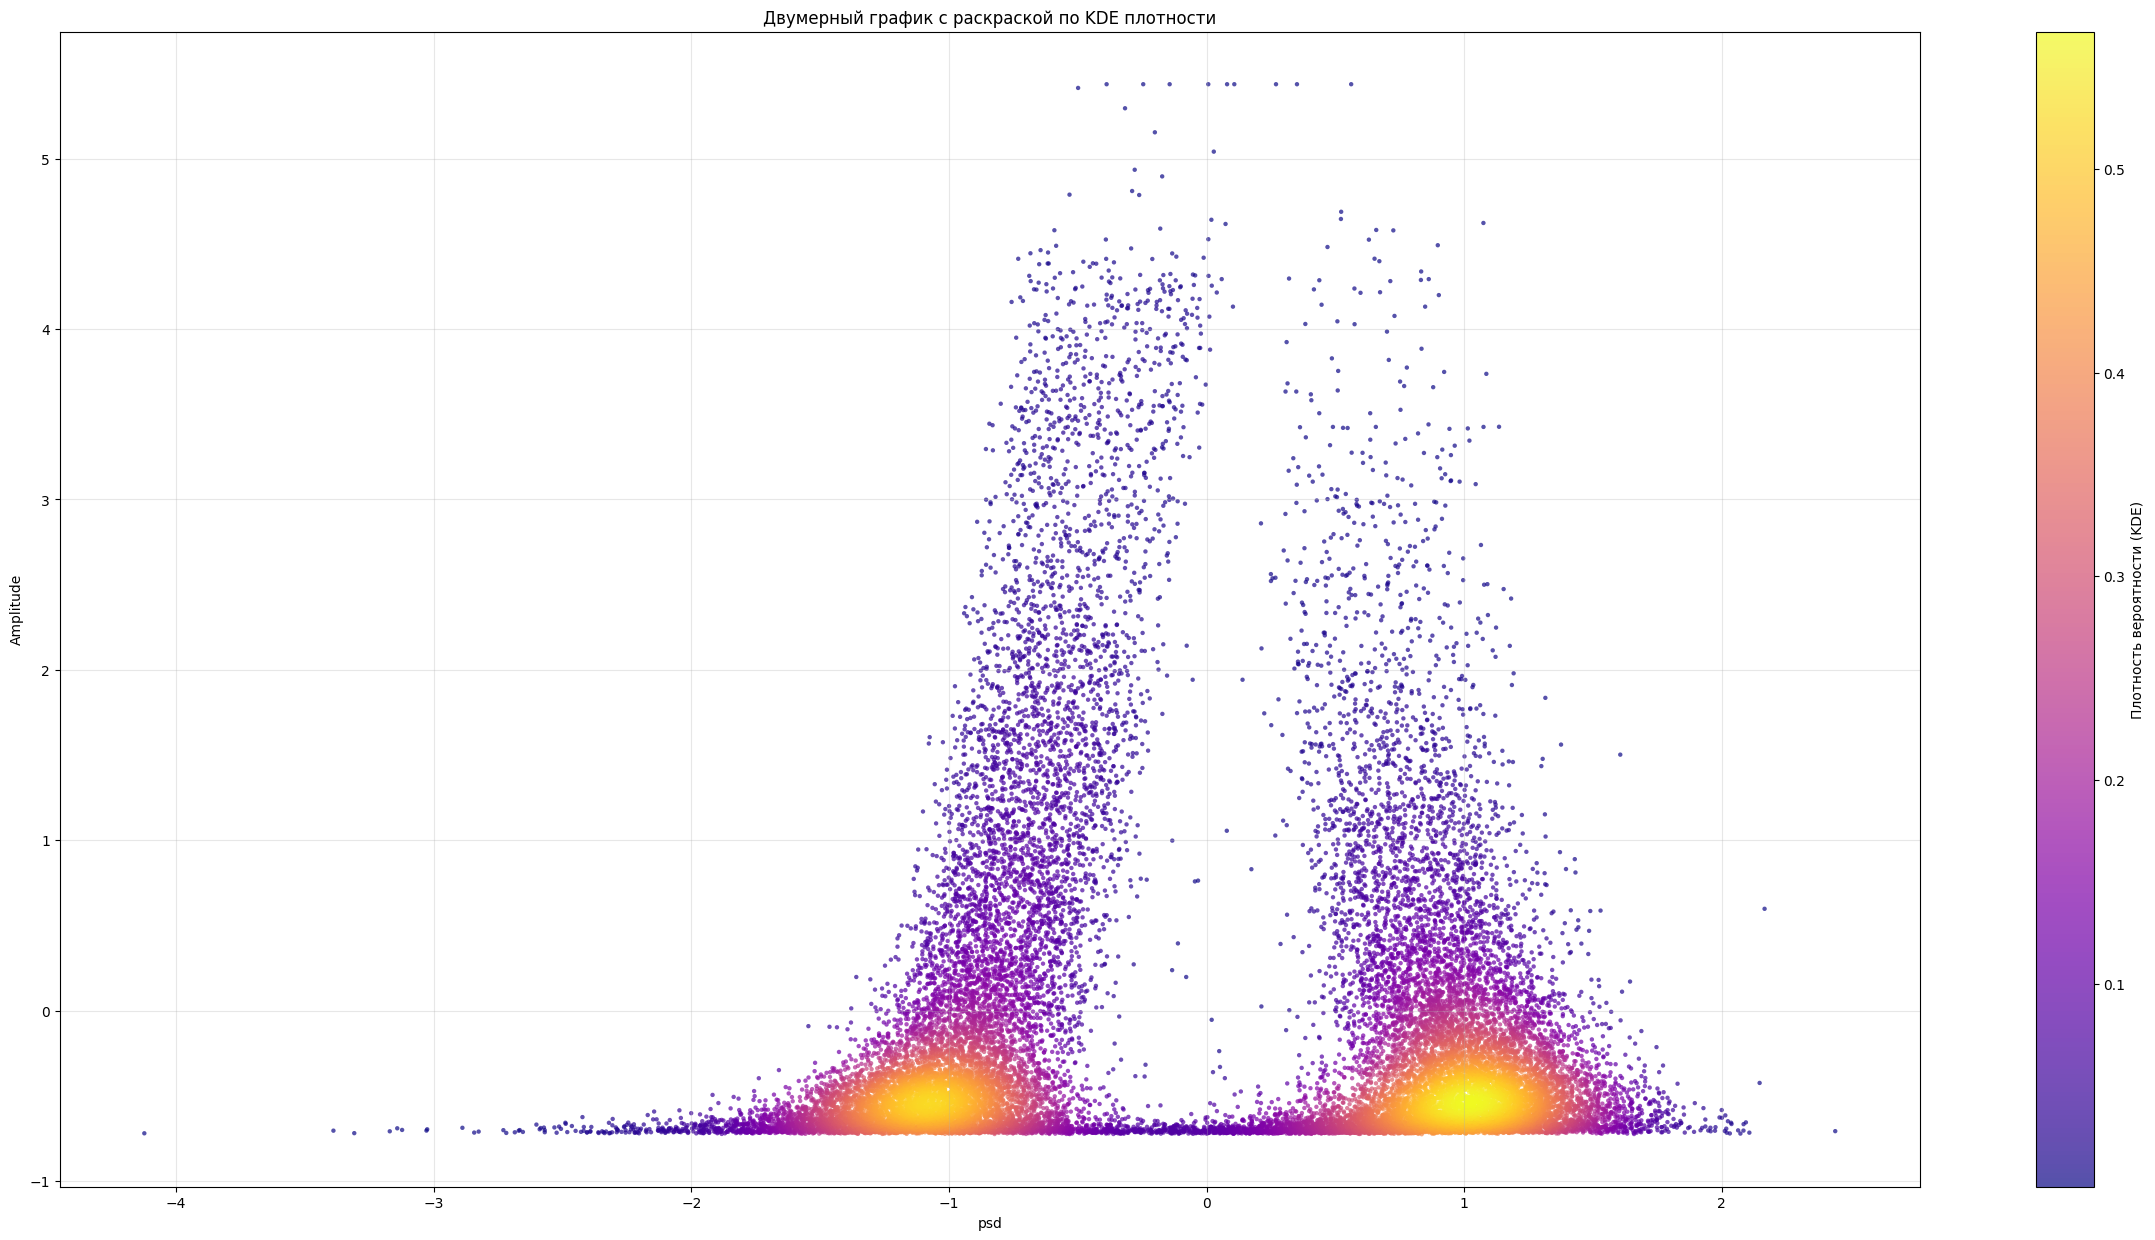

In [93]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# X_scaled — numpy.ndarray с 2 колонками: 0 -> psd, 1 -> amplitude
psd_scaled = X_scaled[:, 0]
amplitude_scaled = X_scaled[:, 1]

plt.figure(figsize=(30, 15))

# Вычисляем ядерную оценку плотности
xy = np.vstack([psd_scaled, amplitude_scaled])
kde = gaussian_kde(xy)
density = kde(xy)

# Сортируем точки по плотности для правильного отображения
sorted_idx = density.argsort()

plt.scatter(psd_scaled[sorted_idx], 
            amplitude_scaled[sorted_idx], 
            c=density[sorted_idx], 
            cmap='plasma',  # цветовая карта
            s=10,  # размер точек
            alpha=0.7,
            edgecolors='none')

# Добавляем colorbar
plt.colorbar(label='Плотность вероятности (KDE)')

plt.xlabel("psd")
plt.ylabel("Amplitude")
plt.title("Двумерный график с раскраской по KDE плотности")
plt.grid(True, alpha=0.3)
plt.show()


In [94]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=2, random_state=40, n_init=10)
df['clusters'] = kmeans1.fit_predict(X_scaled)

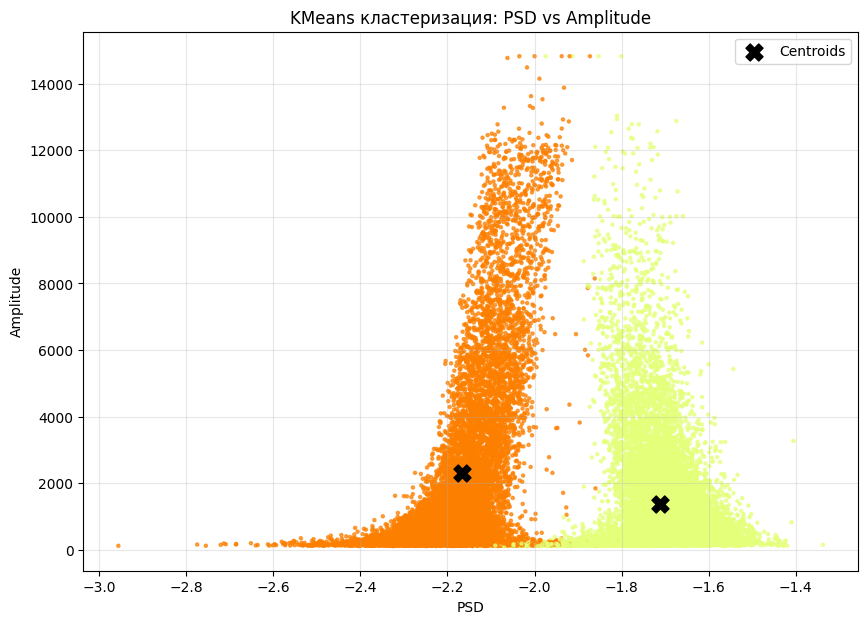

In [103]:
# Центроиды в оригинальных координатах
centroids_scaled = kmeans1.cluster_centers_
centroids = scaler1.inverse_transform(centroids_scaled)

# Визуализация
plt.figure(figsize=(10,7))
plt.scatter(df['psd'], df['amplitude'], c=df['clusters'], cmap='Wistia_r', s=5, alpha=0.7)
plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='X', s=150, label='Centroids')

plt.xlabel('PSD')
plt.ylabel('Amplitude')
plt.title('KMeans кластеризация: PSD vs Amplitude')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [105]:
clusters_raw = kmeans1.fit_predict(X_scaled)

# Формирование таблицы для submission
df_submission = pd.DataFrame({
    'index': np.arange(len(clusters_raw)),
    'cluster': clusters_raw
})
df_submission['cluster'] = df_submission['cluster'].map({0:1, 1:0})
# Сохранение в CSV
df_submission.to_csv('submission.csv', index=False)

In [96]:
df['phi'] = df['amplitude'] / df['volume']

In [97]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['psd', 'phi']])

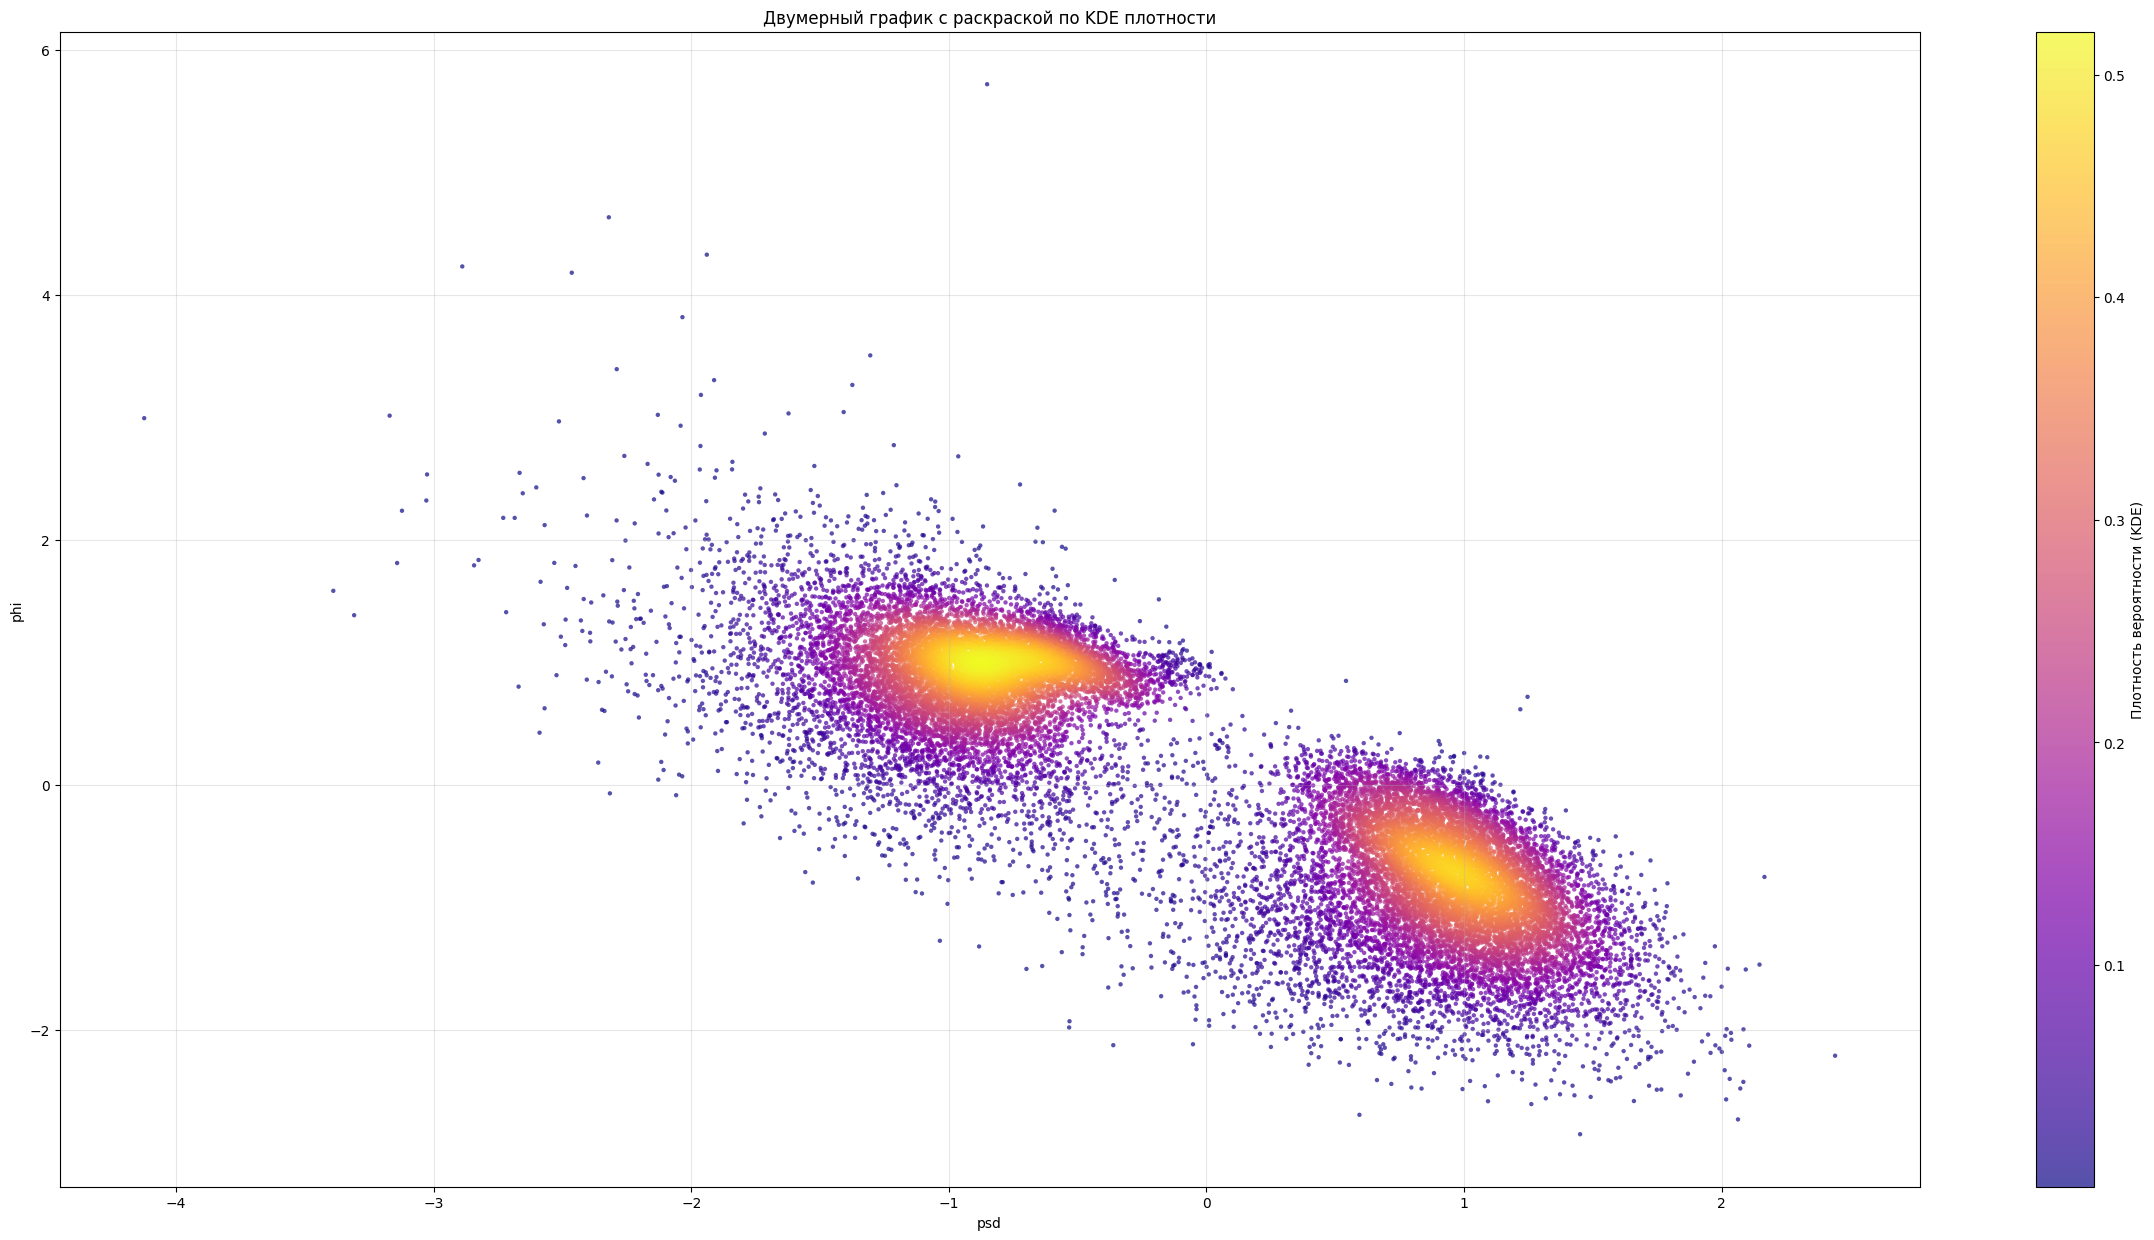

In [98]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# X_scaled — numpy.ndarray с 2 колонками: 0 -> psd, 1 -> amplitude
psd_scaled = X_scaled[:, 0]
amplitude_scaled = X_scaled[:, 1]

plt.figure(figsize=(30, 15))

# Вычисляем ядерную оценку плотности
xy = np.vstack([psd_scaled, amplitude_scaled])
kde = gaussian_kde(xy)
density = kde(xy)

# Сортируем точки по плотности для правильного отображения
sorted_idx = density.argsort()

plt.scatter(psd_scaled[sorted_idx], 
            amplitude_scaled[sorted_idx], 
            c=density[sorted_idx], 
            cmap='plasma',  # цветовая карта
            s=10,  # размер точек
            alpha=0.7,
            edgecolors='none')

# Добавляем colorbar
plt.colorbar(label='Плотность вероятности (KDE)')

plt.xlabel("psd")
plt.ylabel("phi")
plt.title("Двумерный график с раскраской по KDE плотности")
plt.grid(True, alpha=0.3)
plt.show()


In [99]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=40, n_init=10)
df['clusters'] = kmeans.fit_predict(X_scaled)

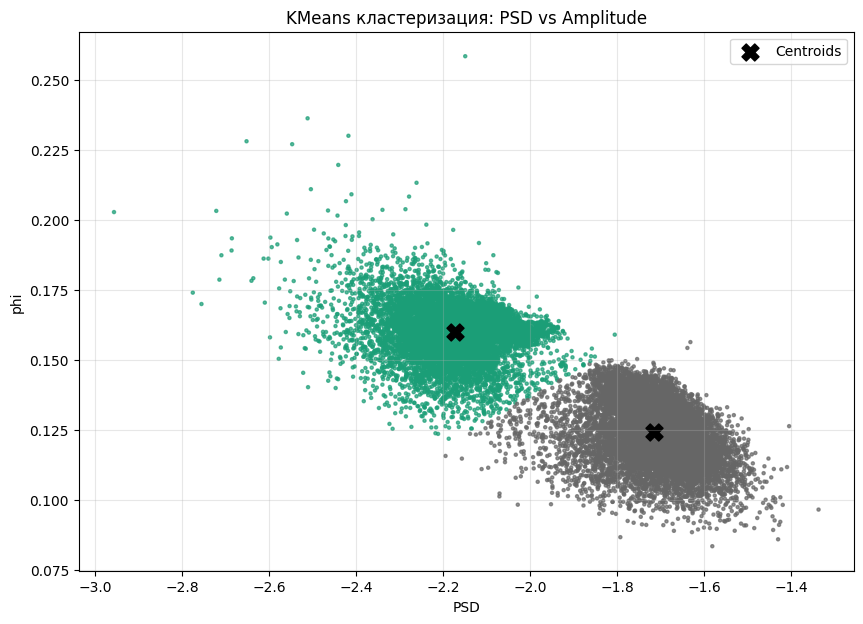

In [100]:
# Центроиды в оригинальных координатах
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

# Визуализация
plt.figure(figsize=(10,7))
plt.scatter(df['psd'], df['phi'], c=df['clusters'], cmap='Dark2', s=5, alpha=0.7)
plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='X', s=150, label='Centroids')

plt.xlabel('PSD')
plt.ylabel('phi')
plt.title('KMeans кластеризация: PSD vs Amplitude')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [102]:
clusters_raw = kmeans.fit_predict(X_scaled)

# Формирование таблицы для submission
df_submission = pd.DataFrame({
    'index': np.arange(len(clusters_raw)),
    'cluster': clusters_raw
})
df_submission['cluster'] = df_submission['cluster'].map({0:1, 1:0})
# Сохранение в CSV
df_submission.to_csv('submission.csv', index=False)